In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img ,img_to_array
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import random

### Image Visualization

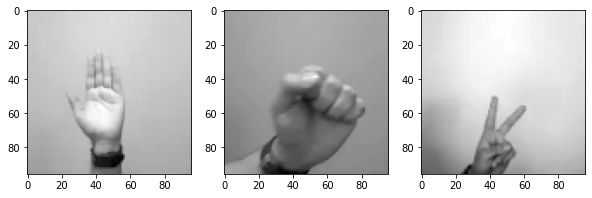

In [2]:
traindir = './rock_paper_scissor/train/'
testdir = './rock_paper_scissor/test'
i = 0
img = ""
fig, ax = plt.subplots(1,3, figsize = (10,10))
for dir in os.listdir(traindir):
    temp = os.path.join(traindir,dir)
    for path in os.listdir(temp):
        path = os.path.join(temp,path)
        img = mpimg.imread(path)
        ax[i].imshow(img, cmap = 'gray')
        i+=1
        break

### Image Augmentation

In [3]:
def fill(img, h, w, direct):
    img = cv.resize(img, (h, w), cv.INTER_CUBIC)
    
    '''if direct == 0:
        add = h - img.shape[0]
        img = cv.copyMakeBorder(img,top=add,bottom=0,left=0,right=0,borderType=cv.BORDER_REPLICATE)
    elif direct == 1:
        add = w - img.shape[1]
        img = cv.copyMakeBorder(img,top=0,bottom=0,left=0,right=add,borderType=cv.BORDER_REPLICATE)
    elif direct == 2:
        add = h - img.shape[0]
        img = cv.copyMakeBorder(img,top=0,bottom=add,left=0,right=0,borderType=cv.BORDER_REPLICATE)
    elif direct == 3:
        add = w - img.shape[1]
        img = cv.copyMakeBorder(img,top=0,bottom=0,left=add,right=0,borderType=cv.BORDER_REPLICATE)
    elif direct == 4:
        add1 = h - img.shape[0]/2
        add2 = w - img.shape[1]/2
        img = cv.copyMakeBorder(img,top=add1,bottom=add1,left=add2,right=add2,borderType=cv.BORDER_REPLICATE)'''
    
    #img = img.reshape(h,w,1)
    return img

def h_shift(image, rate):
    #print(image.shape)
    rate = random.randint(-rate,rate)
    rate = rate/100
    h, w = image.shape[:2]
    direct = -1
    m = w * rate
    if m>=0: #shift right
        image = image[:,:int(w-m)]
        direct = 3
    else:
        m = m*-1
        image = image[:,int(m):]
        direct = 1
    image = fill(image,h,w,direct)
    return image
    
def v_shift(image, rate):
    #print(image.shape)
    rate = random.randint(-rate,rate)
    rate = rate/100
    h, w = image.shape[:2]
    direct = -1
    m = h * rate
    if m>=0: #shift up
        image = image[int(m):,:]
        direct = 2
    else:
        m = m*-1
        image = image[:int(h-m),:]
        direct = 0
    image = fill(image,h,w,direct)
    return image

def bright(image, rate):
    #print(image.shape)
    rate = random.randint(-rate,rate)
    rate = rate/100
    image = image + rate
    return image

def h_flip(image):
    #print(image.shape)
    image = cv.flip(image,1)
    return image

def zoom(image, rate):
    #print(image.shape)
    rate = random.randint(0,rate)
    rate = rate/100
    h, w = image.shape[:2]
    h_start = h*rate/2
    h_end = h - h_start
    w_start = w*rate/2
    w_end = w-w_start
    image = image[int(h_start):int(h_end),int(w_start):int(w_end)]
    image = fill(image,h,w,4)
    return image

func_list = [h_shift, v_shift, bright, zoom]
def img_aug(image, rate):
    mylist = [i for i in range(len(func_list))]
    choices = random.randint(1,len(mylist))
    mylist = random.sample(mylist,choices)
    #print(mylist)
    for j in mylist:
        image = func_list[j](image, rate)
    return image


### Data Preparation

In [6]:
classes = ['paper', 'rock', 'cissor']
for dir in os.listdir(traindir):
    temp = os.path.join(traindir,dir)
    for path in os.listdir(temp):
        path = os.path.join(temp,path)
        img = mpimg.imread(path)
        if dir == classes[0]:
            train_label.append(0)
        elif dir == classes[1]:
            train_label.append(1)
        else:
            train_label.append(2)
        train_set.append(img)

In [7]:
for dir in os.listdir(testdir):
    temp = os.path.join(testdir,dir)
    for path in os.listdir(temp):
        path = os.path.join(temp,path)
        img = mpimg.imread(path)
        if dir == classes[0]:
            test_label.append(0)
        elif dir == classes[1]:
            test_label.append(1)
        else:
            test_label.append(2)
        test_set.append(img)

In [8]:
n = len(train_set)
for i in range(n):
    train_set.append(img_aug(train_set[i],10))
    train_label.append(train_label[i])

In [9]:
train_set = np.array(train_set)
train_label = np.array(train_label)
test_set = np.array(test_set)
test_label = np.array(test_label)

In [10]:
train_set.shape
train_label.shape

In [11]:
train_set = train_set.reshape(train_set.shape[0],96,96,1)
test_set = test_set.reshape(test_set.shape[0],96,96,1)

In [13]:
tf.keras.backend.clear_session() #for cleaning the model in the background, exectute this line if rebuild the program

### Building Model

In [14]:
def mymodel(): 
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3,3), strides = 2, activation='relu', input_shape = (96,96,1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(3))

    return model

In [15]:
model = mymodel()
model.summary()

In [16]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
history = model.fit(train_set, train_label, epochs=10, 
                    validation_data=(test_set, test_label))
#adagrad:0.66
#adadelta: 0.29
#adamax: 0.93
#nadam: 0.97

### Prediction

In [18]:
t = train_set[0]
t = t.reshape(-1,96,96,1)
predict_x=model.predict(t) 
classes_x=np.argmax(predict_x,axis=1)

In [19]:
classes_x